이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter12_part03_neural-style-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

## 뉴럴 스타일 트랜스퍼

### 콘텐츠 손실

### 스타일 손실

### 케라스로 뉴럴 스타일 트랜스퍼 구현하기

**스타일 이미지와 콘텐츠 이미지 준비하기**

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 1s 1us/step


In [14]:
print(original_width, original_height) # 원본 타겟 이미지의 사이즈
print(img_width, img_height)           # 원본 이미지를 전처리한 사이즈

1947 1460
533 400


In [12]:
%pwd

'/content'

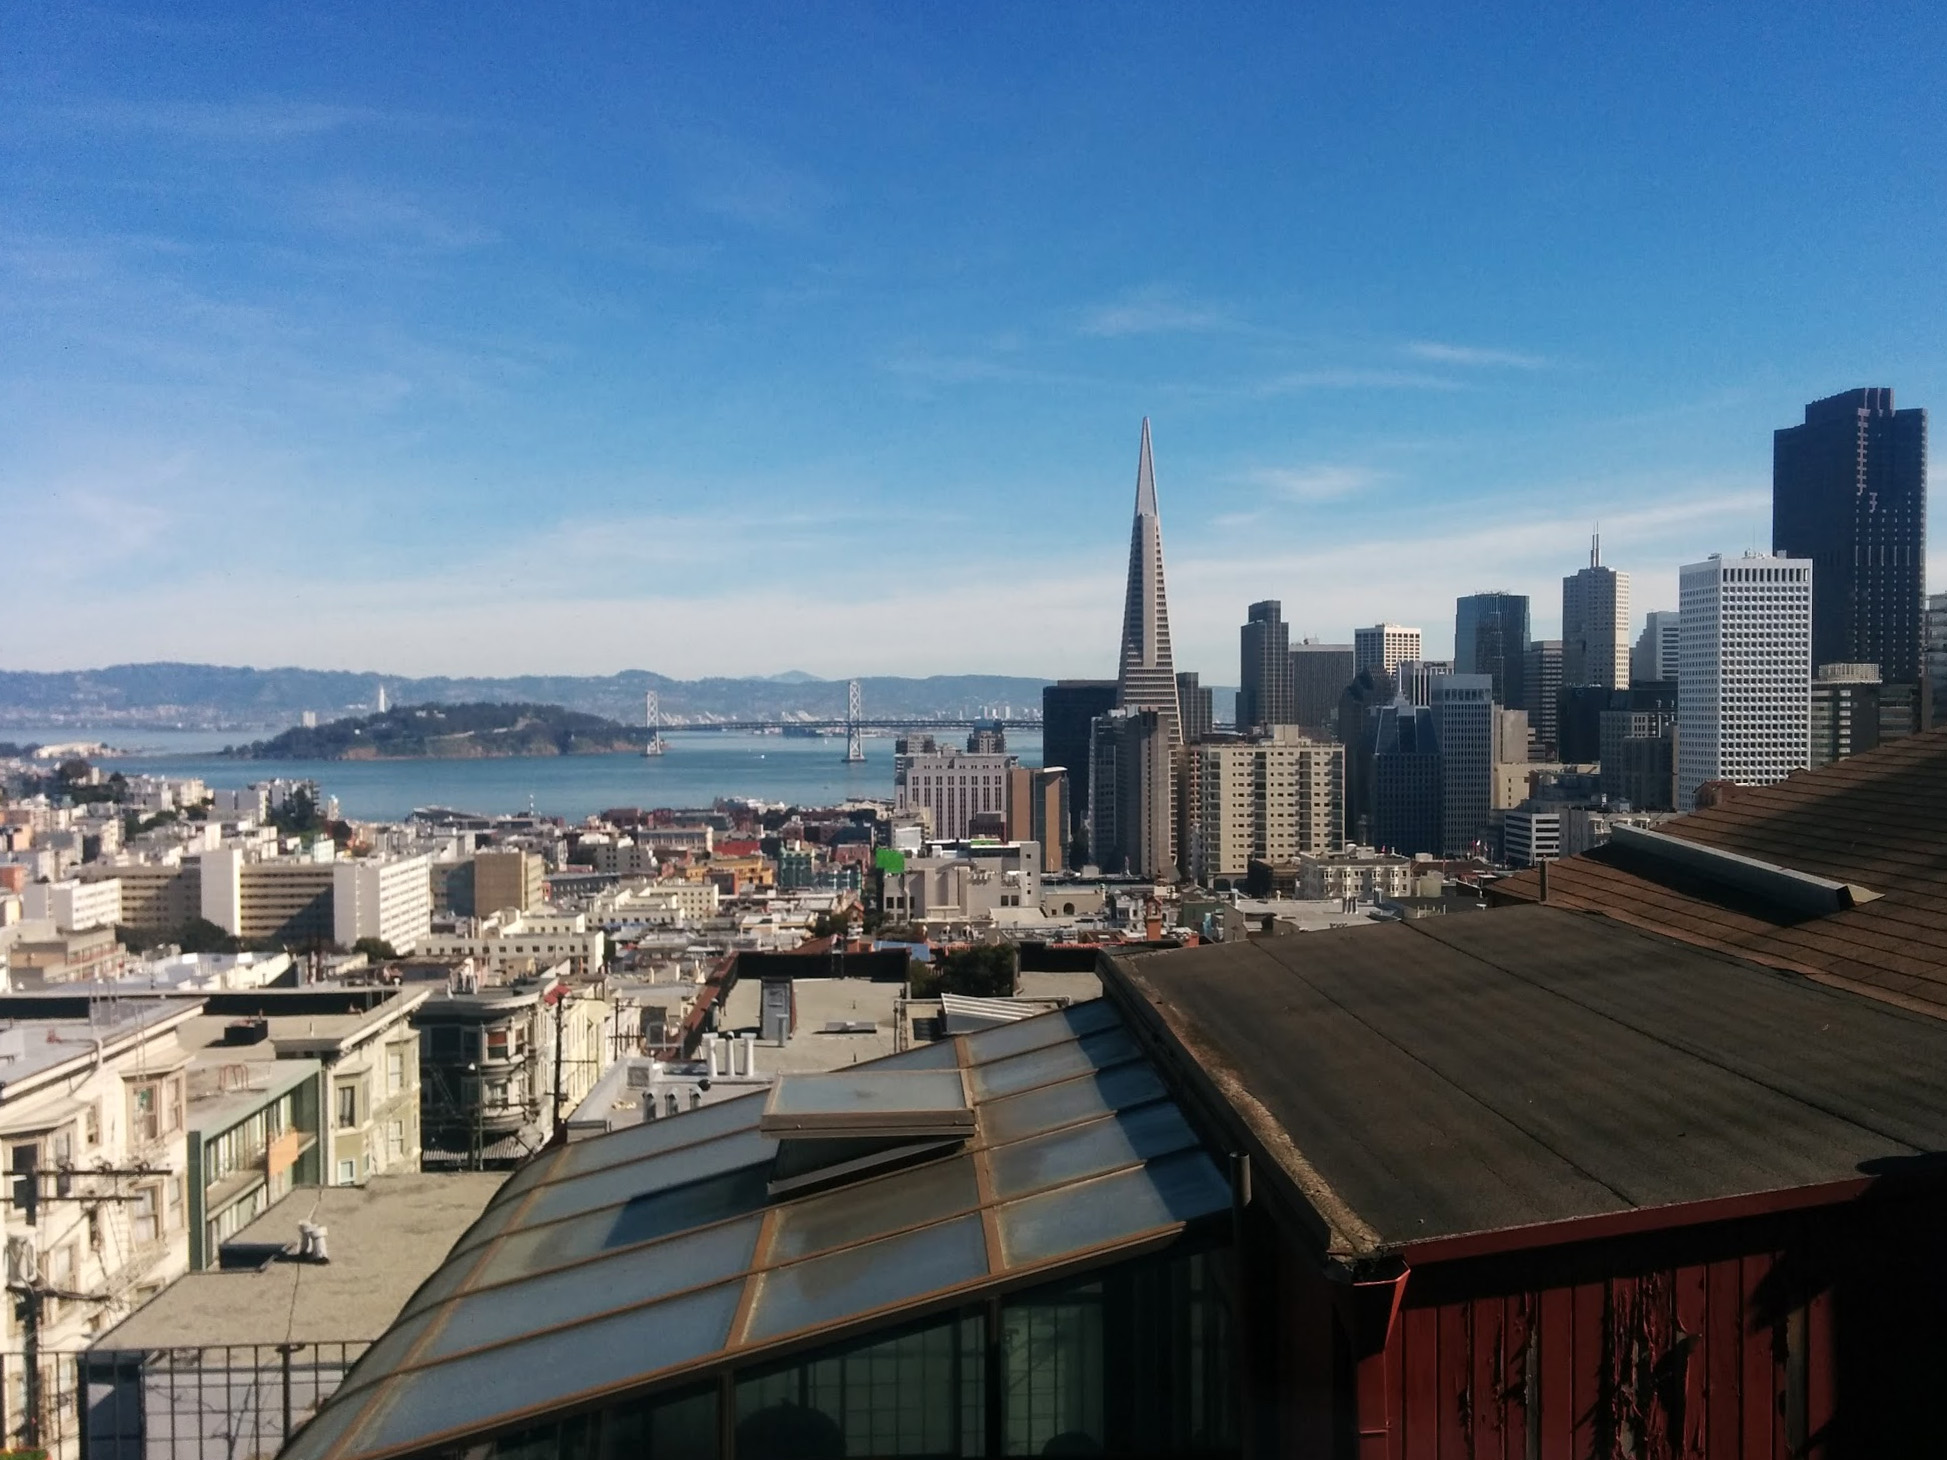

In [5]:
from IPython.display import Image
Image('https://img-datasets.s3.amazonaws.com/sf.jpg')

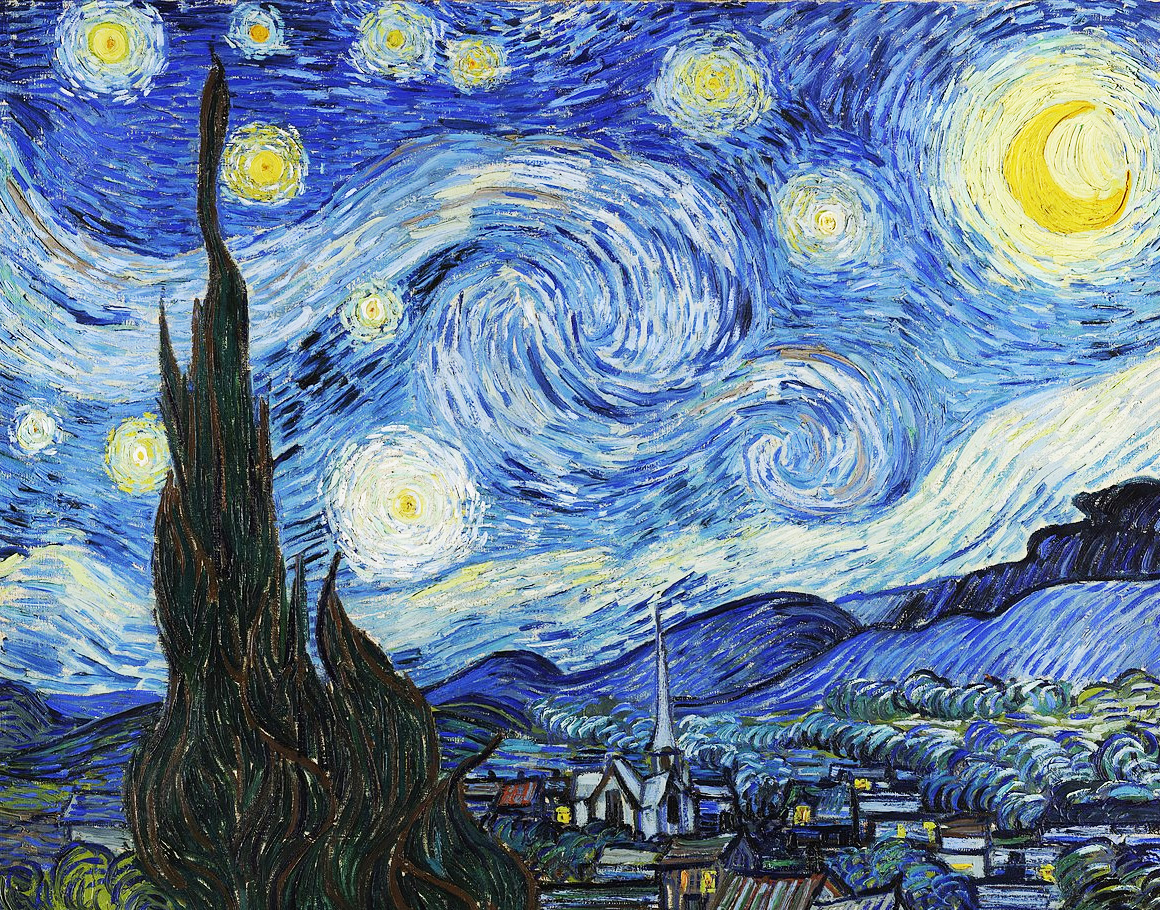

In [13]:
Image('https://img-datasets.s3.amazonaws.com/starry_night.jpg')

**유틸리티 함수**

In [15]:
import numpy as np

# BGR 포맷의 Image channel-wise zero centered IMAGE with no scalling
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width)) # (400, 533)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0) # (1, 400, 533, 3)
    # RGB -> BGR, each color channel is zero-centered with respect to the ImageNet, without scaling
    img = keras.applications.vgg19.preprocess_input(img)
    return img # (1, H, W, 3)

# 원 이미지 사이즈로 복원하고 [0, 255] 쉬프트시키고,  RGB 포맷으로 복원
def deprocess_image(img): # img.shape = (1, H, W, 3)
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**사전 훈련된 VGG19 모델을 사용해 특성 추출기 만들기**

In [16]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 0s 0us/step


**콘텐츠 손실**

In [17]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

**스타일 손실**

In [18]:
def gram_matrix(x):
    # (h, w, c) => (c, h, w) : channel last
    x = tf.transpose(x, (2, 0, 1))
    # (c, h, w) => (c, h*w)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    # (c, c) = (c, h*w) . (h*w, c)
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    # style error에 대한 MSE
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**총 변위 손실**

In [19]:
# 인접 픽셀간의 차이를 나타내는 손실: 이미지의 픽셀간 연속성을 보장하기 위한 손실
def total_variation_loss(x):
    # 수직 1 픽셀간의 차의 제곱
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    # 수평 1 픽셀간의 차의 제곱
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

**최소화할 최종 손실 정의하기**

In [20]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6 # 변위 손실 기여도 = 1
style_weight = 1e-6           # 스타일손실 기여도= 1
content_weight = 2.5e-8       # 컨텐츠손실 기여도= 1/40

# 총손실 = cw*cLoss + sw*sLoss + vw*vLoss
# - 콘텐츠 정보는 좀 잃어버리더라고 스타일을 유지하고, 픽셀간의 연속성을 유지해줘.
# - combination_image, base_image, style_reference_image: 이미지 텐서 객체
def compute_loss(combination_image, base_image, style_reference_image):
    # [(1,H,W,3), (1,H,W,3), (1,H,W,3)]
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    ) # (3, H, W, 3)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=()) # scala tensor
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]   # content activation of content image
    combination_features = layer_features[2, :, :, :]  # content activation of generation image
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :] # style activation of style image
        combination_features = layer_features[2, :, :, :]     # style activation of generation image
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

**경사 하강법 단계 설정하기**

In [ ]:
import tensorflow as tf

# base_image, style_reference_image: 전처리된 상수 텐서, combination_image: 전처리된 변수텐서
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"{i}번째 반복: loss={loss:.2f}")
        # 원 이미지 사이즈로 복원시키고, RGB 포맷으로 변경해서 numpy 이미지로 리턴
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

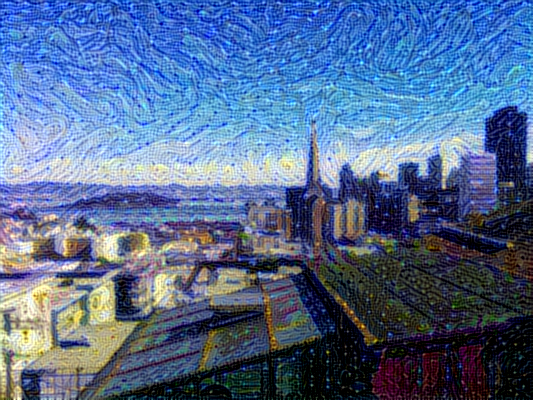

In [22]:
Image(f'combination_image_at_iteration_{4000}.png')

### 정리